<a href="https://colab.research.google.com/github/fbeilstein/dbms/blob/master/DB_lecture_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**B-Tree Basics**

Storage structures can be classified: **mutable** and **immutable**

Most of the **mutable** storage structures use an **inplace** update mechanism. During insert, delete, or update operations, data records are updated directly in their locations in the target file.

Storage engines often allow multiple versions of the same data record to be present in the database but **for now** we assume that **each key is associated only with one data record**, which has a unique location.


One of the most popular storage structures is a **B-Tree**. Many open source database systems are B-Tree based, and over the years they’ve proven to cover the majority of use cases.


B-Trees are not a recent invention: they were introduced by Rudolph Bayer and
Edward M. McCreight back in 1971 and gained popularity over the years. By 1979,
there were already quite a few variants of B-Trees.

**Binary Search Trees**


A binary search tree (BST) is a sorted in-memory data structure, used for efficient key-value lookups. 

BSTs consist of multiple nodes. Each tree node is represented by a key, a value associated with this key, and two child pointers (hence the name binary). BSTs start from a single node, called a **root node**. There can be only one root in the tree. 

Each node splits the search space into left and right subtrees: a node key is greater than any key stored in its left subtree and less than any key stored
in its right subtree.


Following **left** pointers from the root of the tree down to the leaf level (the level where nodes have no children) locates the node holding the **smallest** key within the tree and a value associated with it. Similarly, following **right** pointers locates the node holding the **largest** key within the tree and a value associated with it. 

Values are allowed to be stored in all nodes in the tree. Searches start from the root node, and may terminate before reaching the bottom level of the tree if the searched key was found on a higher level.

**Tree Balancing**


Insert operations do not follow any specific pattern, and element insertion might lead to the situation where the tree is **unbalanced** (i.e., one of its branches is longer than the other one). The worst-case scenario is where we end up with a pathological tree, which looks more like a linked list, and **instead of desired logarithmic complexity, we get linear**. This example might slightly exaggerate the problem, but it illustrates why the tree needs to be balanced: even though it’s somewhat unlikely that all the items end up on one side of the tree, at least some of them certainly will, which will significantly slow down searches.


The balanced tree is defined as one that has a height of $\log_2 N$, where $N$ is the total number of items in the tree, and the difference in height between the two subtrees is not greater than one. 

Without balancing, we lose performance benefits of the binary search tree structure, and allow insertions and deletions order to determine tree shape.

In the balanced tree, following the left or right node pointer reduces the search space in half on average, so lookup complexity is logarithmic: $O(\log_2 N)$. If the tree is not balanced, worst-case complexity goes up to $O(N)$, since we might end up in the situation where all elements end up on one side of the tree.


Instead of adding new elements to one of the tree branches and making it longer,
while the other one remains empty, the tree is **balanced** after each operation. Balancing is done by reorganizing nodes in a way that minimizes tree height and keeps the number of nodes on each side within bounds.

**Trees for Disk-Based Storage**

BSTs are impractical as on-disk data structures.

If we wanted to maintain a BST on disk, we'd face several problems. One problem is **locality**: since elements are added in random order, there’s no guarantee that a newly created node is written close to its parent, which means that node **child pointers may span across several disk pages**. 


Another problem, closely related to the cost of following child pointers, is tree height. Since binary trees have a **fanout** of just two, height is a binary logarithm of the number of the elements in the tree, and we have to perform $O(\log_2 N)$ seeks to locate the searched element and, subsequently, perform the same number of disk transfers. 

2-3-Trees and other low-fanout trees have a similar limitation: while they are useful as in-memory data structures, small node size makes them impractical for external storage.


A naive on-disk BST implementation would require as many disk seeks as comparisons, since there’s no built-in concept of locality. This sets us on a course to look for a data structure that would exhibit this property.

Considering these factors, a version of the tree that would be better suited for disk implementation has to exhibit the following properties:
* High fanout to improve locality of the neighboring keys.
* Low height to reduce the number of seeks during traversal.

**Disk-Based Structures**


Not every data structure that satisfies space and complexity requirements can be effectively used for on-disk storage. Data structures used in databases have to be adapted to account for persistent medium limitations.

On-disk data structures are often used when the amounts of data are so large that keeping an entire dataset in memory is impossible or not feasible. Only a fraction of the data can be cached in memory at any time, and the rest has to be stored on disk in a manner that allows efficiently accessing it.

**Hard Disk Drives**


Most traditional algorithms were developed when **spinning disks** were the most widespread persistent storage medium, which significantly influenced their design. 

Later, new developments in storage media, such as **flash drives**, inspired new algorithms and modifications to the existing ones, exploiting the capabilities of the new hardware. 

On spinning disks, **seeks** increase costs of random reads because they require disk rotation and mechanical head movements to position the read/write head to the desired location. 

However, once the expensive part is done, reading or writing contiguous bytes (i.e., sequential operations) is relatively cheap.

The smallest transfer unit of a spinning drive is a sector, so when some operation is performed, at least an entire sector can be read or written. Sector sizes typically range from 512 bytes to 4 Kb.

Head positioning is the most expensive part of an operation on the HDD. This is one of the reasons we often hear about the positive effects of sequential I/O: reading and writing contiguous memory segments from disk.

**Solid State Drives**


Solid state drives (SSDs) do not have moving parts: there’s no disk that spins, or head that has to be positioned for the read. A typical SSD is built of **memory cells**, connected into **strings** (typically 32 to 64 cells per string), strings are combined into **arrays**, arrays are combined into **pages**, and pages are combined into **blocks**.


Depending on the exact technology used, a cell can hold one or multiple bits of data. Pages vary in size between devices, but typically their sizes range from 2 to 16 Kb. Blocks typically contain 64 to 512 pages. Blocks are organized into planes and, finally, planes are placed on a die. SSDs can have one or more dies. 


* The **smallest** unit that can be written (programmed) or read is a **page**.
* We can only make changes to the **empty** memory cells (i.e., to ones that have been erased before the write). 
* The smallest erase entity is not a page, but a **block** that holds multiple pages, which is why it is often called an **erase block**. 
* Pages in an empty block have to be written sequentially.


The part of a flash memory controller responsible for mapping page IDs to their
physical locations, tracking empty, written, and discarded pages, is called the **Flash Translation Layer** (FTL). It is also responsible for garbage collection, during which FTL finds blocks it can safely erase. Some blocks might still contain live pages. In this case, it relocates live pages from these blocks to new locations and remaps page IDs to point there. After this, it erases the now-unused blocks, making them available for writes.


Since in both device types (HDDs and SSDs) we are addressing chunks of memory
rather than individual bytes (i.e., accessing data block-wise), most operating systems have a **block device abstraction**. It hides an internal disk structure and buffers I/O operations internally, so when we’re reading a single word from a block device, the whole block containing it is read. This is a constraint we cannot ignore and should always take into account when working with disk-resident data structures.


In SSDs, we don’t have a strong emphasis on random versus sequential I/O, as in
HDDs, because the difference in latencies between random and sequential reads is
not as large. 

There is still some difference caused by prefetching, reading contiguous pages, and internal parallelism. Even though garbage collection is usually a background operation, its effects may negatively impact write performance, especially in cases of random and unaligned write workloads.

Writing only full blocks, and combining subsequent writes to the same block, can
help to reduce the number of required I/O operations.

**On-Disk Structures**


The main limitation and design condition for building efficient on-disk structures is the fact that the **smallest unit of disk operation is a block**. 

To follow a pointer to the specific location within the block, we have to
fetch an entire block. Since we already have to do that, we can change the layout of the data structure to take advantage of it.

We’ve mentioned pointers several times throughout this chapter already, but this
word has slightly different semantics for on-disk structures. On disk, most of the time we manage the data layout manually (unless, for example, we’re using memory mapped files). This is still similar to regular pointer operations, but we have to compute the target pointer addresses and follow the pointers explicitly.

Most of the time, on-disk offsets are precomputed (in cases when the pointer is written on disk before the part it points to) or cached in memory until they are flushed on the disk. Creating long dependency chains in on-disk structures greatly increases code and structure complexity, so it is preferred to keep the number of pointers and their spans to a minimum.

In summary, on-disk structures are designed with their target storage specifics in mind and generally optimize for fewer disk accesses. We can do this by improving locality, optimizing the internal representation of the structure, and reducing the number of out-of-page pointers.

B-Trees combine these ideas: 
* increase node fanout
* reduce 
  - tree height, 
  - the number of node pointers, 
  - the frequency of balancing operations.

**Paged Binary Tree**

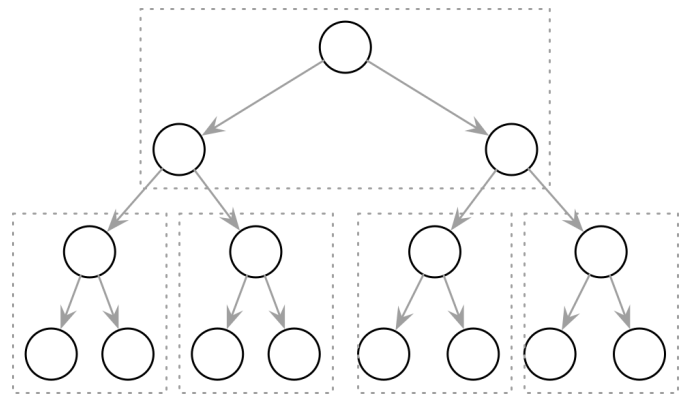

**Ubiquitous B-Trees**


B-Trees build upon the foundation of balanced search trees and are different in that they have higher **fanout** (have more child nodes) and smaller height.

Both structures have similar pointer-following semantics, and differences start showing in how the balance is maintained. 

Keys inside the B-Tree nodes are stored in order. Because of that, to locate a searched key, we can use an algorithm like binary search. This also implies
that lookups in B-Trees have logarithmic complexity. For example, finding a searched key among 4 billion ($4 \times 10^9$) items takes about 32 comparisons. If we had to make a disk seek for each one of these comparisons, it would significantly slow us down, but since B-Tree nodes **store dozens or even hundreds of items**, we only have to make one disk seek per level jump. We’ll discuss a lookup algorithm in more detail later in this chapter.

Using B-Trees, we can efficiently execute both point and range queries. Point queries, expressed by the equality (=) predicate in most query languages, locate a single item.

On the other hand, range queries, expressed by comparison (<, >, ≤, and ≥) predicates, are used to query multiple data items in order.

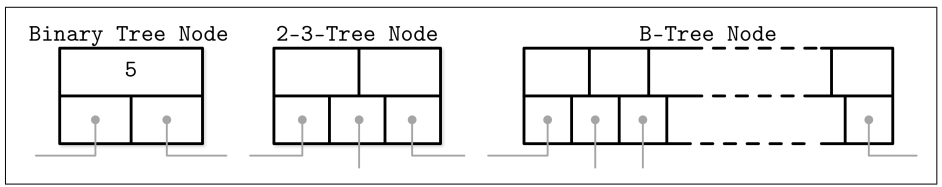

**B-Tree Hierarchy**


B-Trees consist of multiple nodes. Each node holds up to $N$ keys and $N + 1$ pointers to the child nodes. These nodes are logically grouped into three groups:
* **Root node** This has no parents and is the top of the tree.
* **Leaf nodes** These are the bottom layer nodes that have no child nodes.
* **Internal nodes** These are all other nodes, connecting root with leaves. There is usually more than one level of internal nodes.

Since B-Trees are a **page** organization technique (i.e., they are used to organize and navigate fixed-size pages), we often use terms **node** and **page** interchangeably.

The relation between the node capacity and the number of keys it actually holds is called **occupancy**.

B-Trees are characterized by their **fanout**: the number of keys stored in each node. Higher fanout helps to amortize the cost of structural changes required to keep the tree balanced and to reduce the number of seeks by storing keys and pointers to child nodes in a single block or multiple consecutive blocks. Balancing operations (namely, splits and merges) are triggered when the nodes are full or nearly empty.

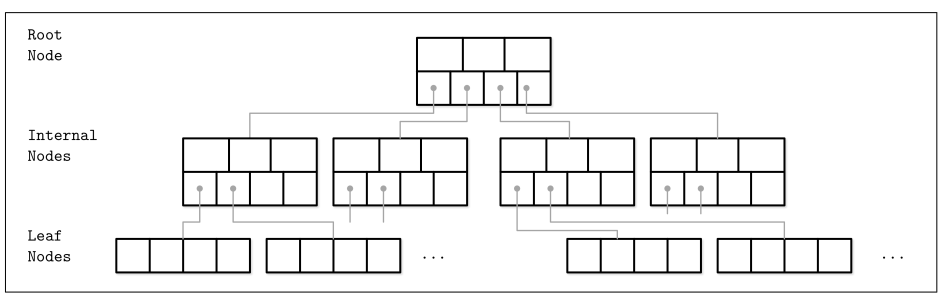

**$B^+$-Trees**

We’re using the term **B-Tree** as an umbrella for a family of data structures that share all or most of the mentioned properties. A more precise name for the described data structure is $B^+$-Tree. Knuth refers to trees with a high fanout as **multiway trees**.


B-Trees allow storing values on any level: in root, internal, and leaf nodes. $B^+$-Trees store values only in leaf nodes. Internal nodes store only separator keys used to guide the search algorithm to the associated value stored on the leaf level.

Since values in $B^+$-Trees are stored only on the leaf level, all operations (inserting, updating, removing, and retrieving data records) affect only leaf nodes and propagate to higher levels only during splits and merges.

MySQL InnoDB and some other refers to its $B^+$-Tree implementation as B-tree.

**Separator Keys**


Keys stored in B-Tree nodes are called **index entries**, **separator keys**, or **divider cells**. They split the tree into **subtrees** (also called **branches** or **subranges**), holding corresponding key ranges. 

**Keys** are stored in **sorted** order to allow binary search. A subtree is found by locating a key and following a corresponding pointer from the higher to the lower level.

* the first pointer in the node points to the subtree holding items less than the first key
* last pointer in the node points to the subtree holding items greater than or equal to the last key
* other pointers are reference subtrees between the two keys: $K_i-1 \leq K_s < K_i$, where K is a set of keys, and Ks is a key that belongs to the subtree.


Some B-Tree variants also have **sibling node pointers**, most often on the leaf level, to simplify range scans. These pointers help avoid going back to the parent to find the next sibling. Some implementations have pointers in both directions, forming a **double-linked list** on the leaf level, which makes the reverse iteration possible.

What sets B-Trees apart is that, rather than being built from top to bottom (as binary search trees), they’re constructed the other way around—from bottom to top. The number of leaf nodes grows, which increases the number of internal nodes and tree height.

Since B-Trees reserve extra space inside nodes for future insertions and updates, tree storage utilization can get as low as 50%, but is usually considerably higher. Higher occupancy does not influence B-Tree performance negatively.

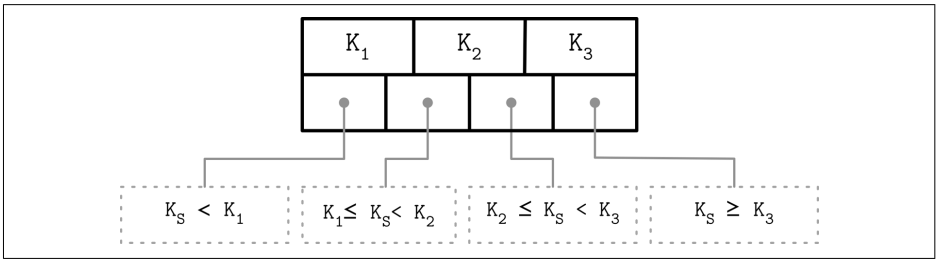

**B-Tree Lookup Complexity**


B-Tree lookup complexity can be viewed from two standpoints: 
* the number of block transfers
* the number of comparisons done during the lookup


In terms of number of transfers, the logarithm base is N (number of keys per node).

There are K times more nodes on each new level, and following a child pointer
reduces the search space by the factor of $N$. During lookup, at most $\log_K M$ (where $M$ is a total number of items in the B-Tree) **pages are addressed** to find a searched key. 

The number of child pointers that have to be followed on the root-to-leaf pass is also equal to the number of levels, in other words, the height $h$ of the tree.

From the perspective of number of comparisons, the logarithm base is 2, since
searching a key inside each node is done using binary search. Every comparison
halves the search space, so complexity is $\log_2 M$. Knowing the distinction between the number of seeks and the number of comparisons helps us gain the intuition about how searches are performed and understand what lookup complexity is, from both perspectives.

In textbooks and articles B-Tree lookup complexity is generally referenced as $\log M$. Logarithm base is generally not used in complexity analysis, since changing the base simply adds a constant factor, and multiplication by a constant factor does not change complexity. For example, given the nonzero constant factor $O(c \times n) = O(n)$.

**B-Tree Lookup Algorithm**

Now that we have covered the structure and internal organization of B-Trees, we can define algorithms for lookups, insertions, and removals. To find an item in a B-Tree, we have to perform **a single traversal** from root to leaf. The objective of this search is to find a searched key or its predecessor. Finding an exact match is used for 
* point queries, 
* updates, 
* deletions; 
finding its predecessor is useful for 
* range scans, 
* inserts.


(1) The algorithm starts from the root and performs a binary search, comparing the searched key with the keys stored in the root node until it finds the first separator key that is greater than the searched value. 

(2) This locates a searched subtree. As we’ve discussed previously, index keys split the tree into subtrees with boundaries between two neighboring keys. As soon as we find the subtree, we follow the pointer that corresponds to it and continue the same search process (1) until we reach a target leaf node, where we either find the searched key or conclude it is not present by locating its predecessor.


During the point query, the search is done after finding or failing to find the searchedbkey. During the range scan, iteration starts from the closest found key-value pair and continues by following sibling pointers until the end of the range is reached or the range predicate is exhausted


**Counting Keys**


Across the literature, you can find different ways to describe key and child offset counts. We will suppose $N$ to be the number of **separator keys** that can be hold in a node (corresponds to $N+1$ pointers). Node can be partially filled, but should hold at least $N/2+1$ keys.

**B-Tree Node Splits**


To insert the value into a B-Tree, we first have to locate the target leaf and find the insertion point. 

After the leaf is located, the key and value are appended to it. Updates in B-Trees work by locating a target leaf node using a lookup algorithm and associating a new value with an existing key.

If the target node doesn’t have enough room available, we say that the node has overflowed and has to be split in two to fit the new data. More precisely, the node is split if the following conditions hold:
* **For leaf nodes**: if the node can hold up to N key-value pairs, and inserting one more key-value pair brings it over its maximum capacity N.
* **For nonleaf nodes**: if the node can hold up to N + 1 pointers, and inserting one more pointer brings it over its maximum capacity N + 1.

Splits are done by allocating the new node, transferring **half** the elements from the splitting node to it, and adding its first key and pointer to the parent node. In this case, we say that the **key is promoted**. The index at which the split is performed is called the **split point** (also called the midpoint). All elements after the split point (including split point in the case of nonleaf node split) are transferred to the newly created sibling node, and the rest of the elements remain in the splitting node.

If the parent node is full and does not have space available for the promoted key and pointer to the newly created node, it has to be split as well. This operation might propagate recursively all the way to the root.

As soon as the tree reaches its capacity (i.e., split propagates all the way up to the root), we have to split the root node. When the root node is split, a new root, holding a split point key, is allocated. The old root (now holding only half the entries) is demoted to the next level along with its newly created sibling, increasing the tree height by one. 

The tree height changes when the root node is split and the new root is allocated, or when two nodes are merged to form a new root. On the leaf and internal node levels, the tree only grows horizontally.



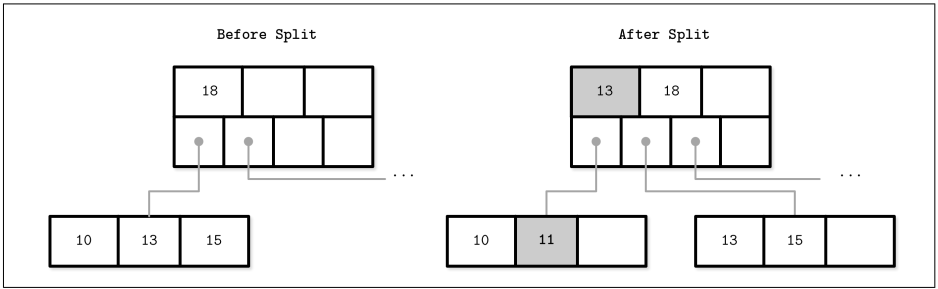

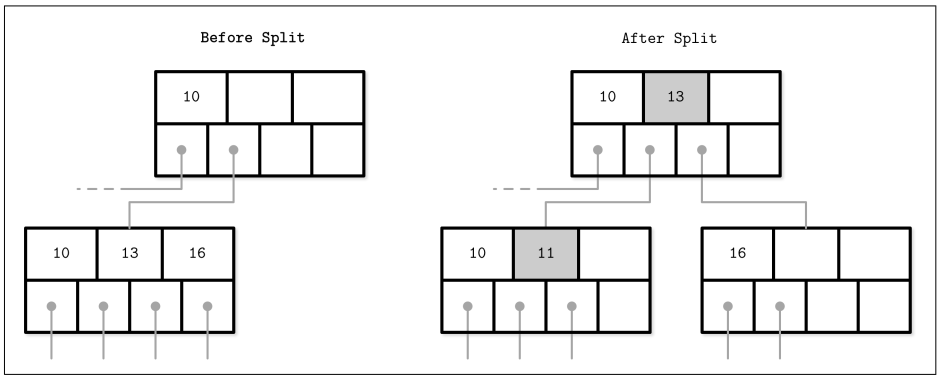

To perform a split, we first create a new node and move elements starting from index N/2 + 1 to it. The split point key is promoted to the parent.

Since nonleaf node splits are always a manifestation of splits propagating from the levels below, we have an additional pointer (to the newly created node on the next level). If the parent does not have enough space, it has to be split as well.

When the split is done, we have two nodes and have to pick the correct one to finish insertion. For that, we can use the separator key invariants. If the inserted key is less than the promoted one, we finish the operation by inserting to the split node. Otherwise, we insert to the newly created one.

To summarize, node splits are done in four steps:
1. Allocate a new node.
2. Copy half the elements from the splitting node to the new one.
3. Place the new element into the corresponding node.
4. At the parent of the split node, add a separator key and a pointer to the new
node


[DEMO](https://www.cs.usfca.edu/~galles/visualization/BPlusTree.html)

insert 10,20,30,15


insert 5 or 11

**B-Tree Node Merges**


Deletions are done by first locating the target leaf. When the leaf is located, the key and the value associated with it are removed.

If neighboring nodes have too few values (i.e., their occupancy falls under a threshold), the sibling nodes are merged. This situation is called underflow. Two underflow scenarios: 
* if two adjacent nodes have a common parent and their contents fit into a single node, their contents should be merged (concatenated);
* if their contents do not fit into a single node, keys are redistributed between them to restore balance. 


More precisely, two nodes are merged if the following conditions hold:
* **For leaf nodes**: if a node can hold up to N key-value pairs, and a combined number of key-value pairs in two neighboring nodes is less than or equal to N.
* **For nonleaf nodes**: if a node can hold up to N + 1 pointers, and a combined
number of pointers in two neighboring nodes is less than or equal to N + 1.

During the merge of nonleaf nodes, we have to pull the corresponding separator key from the parent (i.e., demote it). 

The number of pointers is reduced by one because the merge is a result of the propagation of the pointer deletion from the lower level, caused by the page removal. 

Just as with splits, merges can propagate all the way to the root level.
To summarize, node merges are done in three steps, assuming the element is already removed:
1. Copy all elements from the right node to the left one.
2. Remove the right node pointer from the parent (or demote it in the case of a nonleaf merge).
3. Remove the right node.

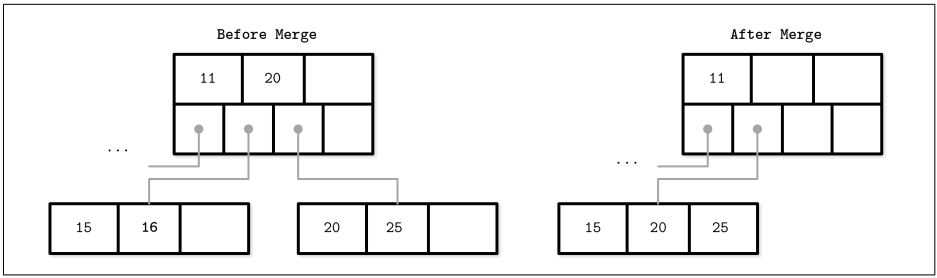

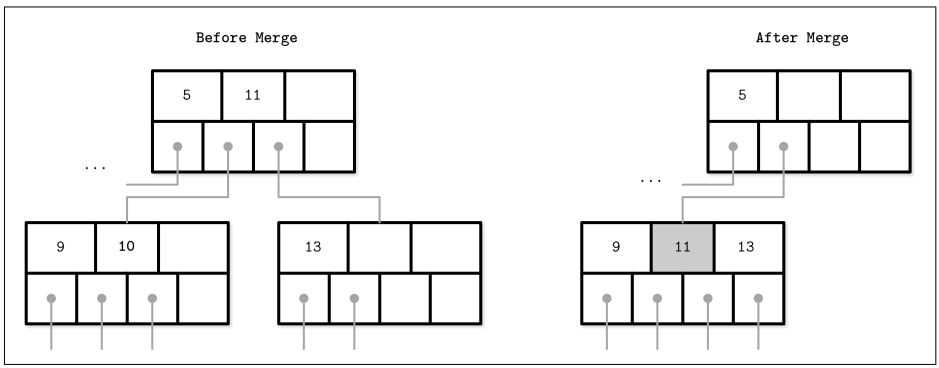